In [1]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(23)

In [2]:
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

In [3]:
image_path = "Water Bodies Dataset/Images/*.jpg"
mask_path = "Water Bodies Dataset/Masks/*.jpg"

In [4]:
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])

In [5]:
train_images_array = []

for image in image_names:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    train_images_array.append(img)
    
train_images_array = np.array(train_images_array)

In [6]:
mask_images_array = []

for mask in mask_names:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_images_array.append(msk)
    
mask_images_array = np.array(mask_images_array)

<h3 style="color:#8D3DAF;">Getting the dimensions of created array</h3>

In [7]:
len(train_images_array)

2841

In [8]:
len(mask_images_array)

2841

In [9]:
train_images_array[0].shape

(128, 128, 3)

In [10]:
mask_images_array[0].shape

(128, 128)

In [7]:
def normalize_array(arr):
    return arr/255.0

X = normalize_array(train_images_array)
y = normalize_array(mask_images_array)

<h3 style="color:#8D3DAF;">Visualizing random images from the original and mask images</h3>

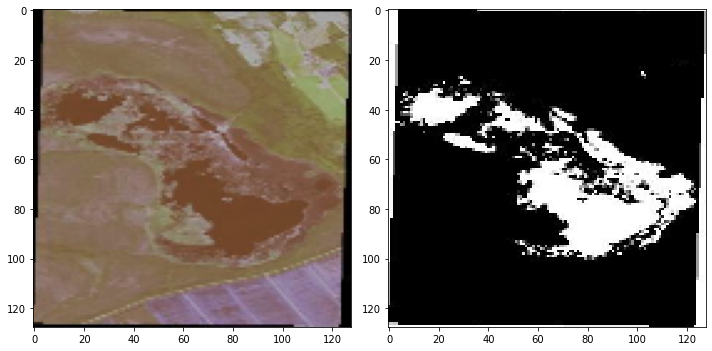

In [12]:
rand_num = random.randint(0,2500)

figure, axes = plt.subplots(1,2, figsize=(10,10))

axes[0].imshow(X[rand_num])

axes[1] = imshow(y[rand_num])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=23)

In [9]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [11]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [13]:
def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
model = unet_model(n_filters=32,input_size=(128,128,3))

model.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  1,179,904 │ dropout_1[0][0] 

 Total params: 8,639,745 (32.96 MB)

 Trainable params: 8,639,745 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb = ModelCheckpoint("model_unet.keras",save_best_only=True)

<h3 style="color:#8D3DAF;">Training the unet model...</h3>

In [21]:
num_epochs = 1

history = model.fit(X_train,y_train,epochs=num_epochs,callbacks=[early_stopping_cb], validation_data=(X_test, y_test))

71/71 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.6315 - loss: 0.5276 - val_accuracy: 0.6488 - val_loss: 0.4748


<h3 style="color:#8D3DAF;">Visualizing the results of training</h3>

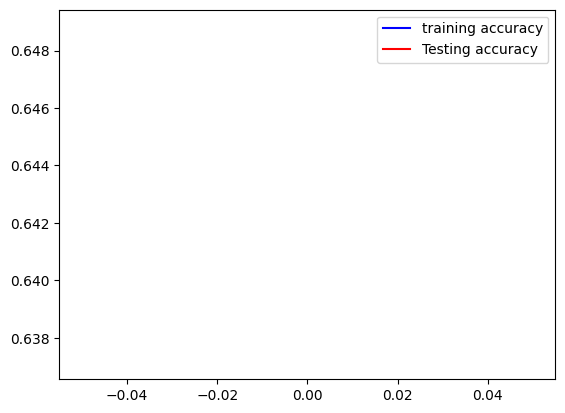

In [23]:
## creating an accuracy graph for training and testing data
plt.plot(history.history['accuracy'],color='blue',label='training accuracy')
plt.plot(history.history['val_accuracy'],color='red',label='Testing accuracy')
plt.legend()
plt.show()

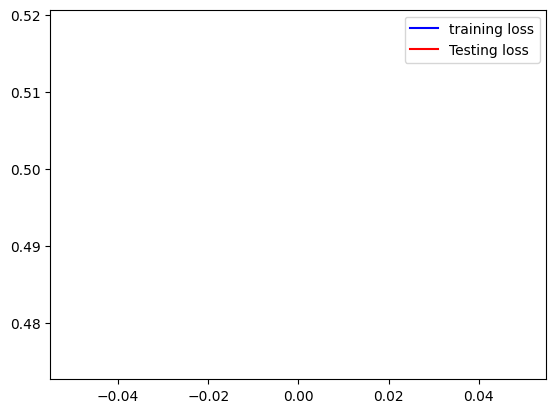

In [24]:
## creating an loss graph for training and testing data
plt.plot(history.history['loss'],color='blue',label='training loss')
plt.plot(history.history['val_loss'],color='red',label='Testing loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


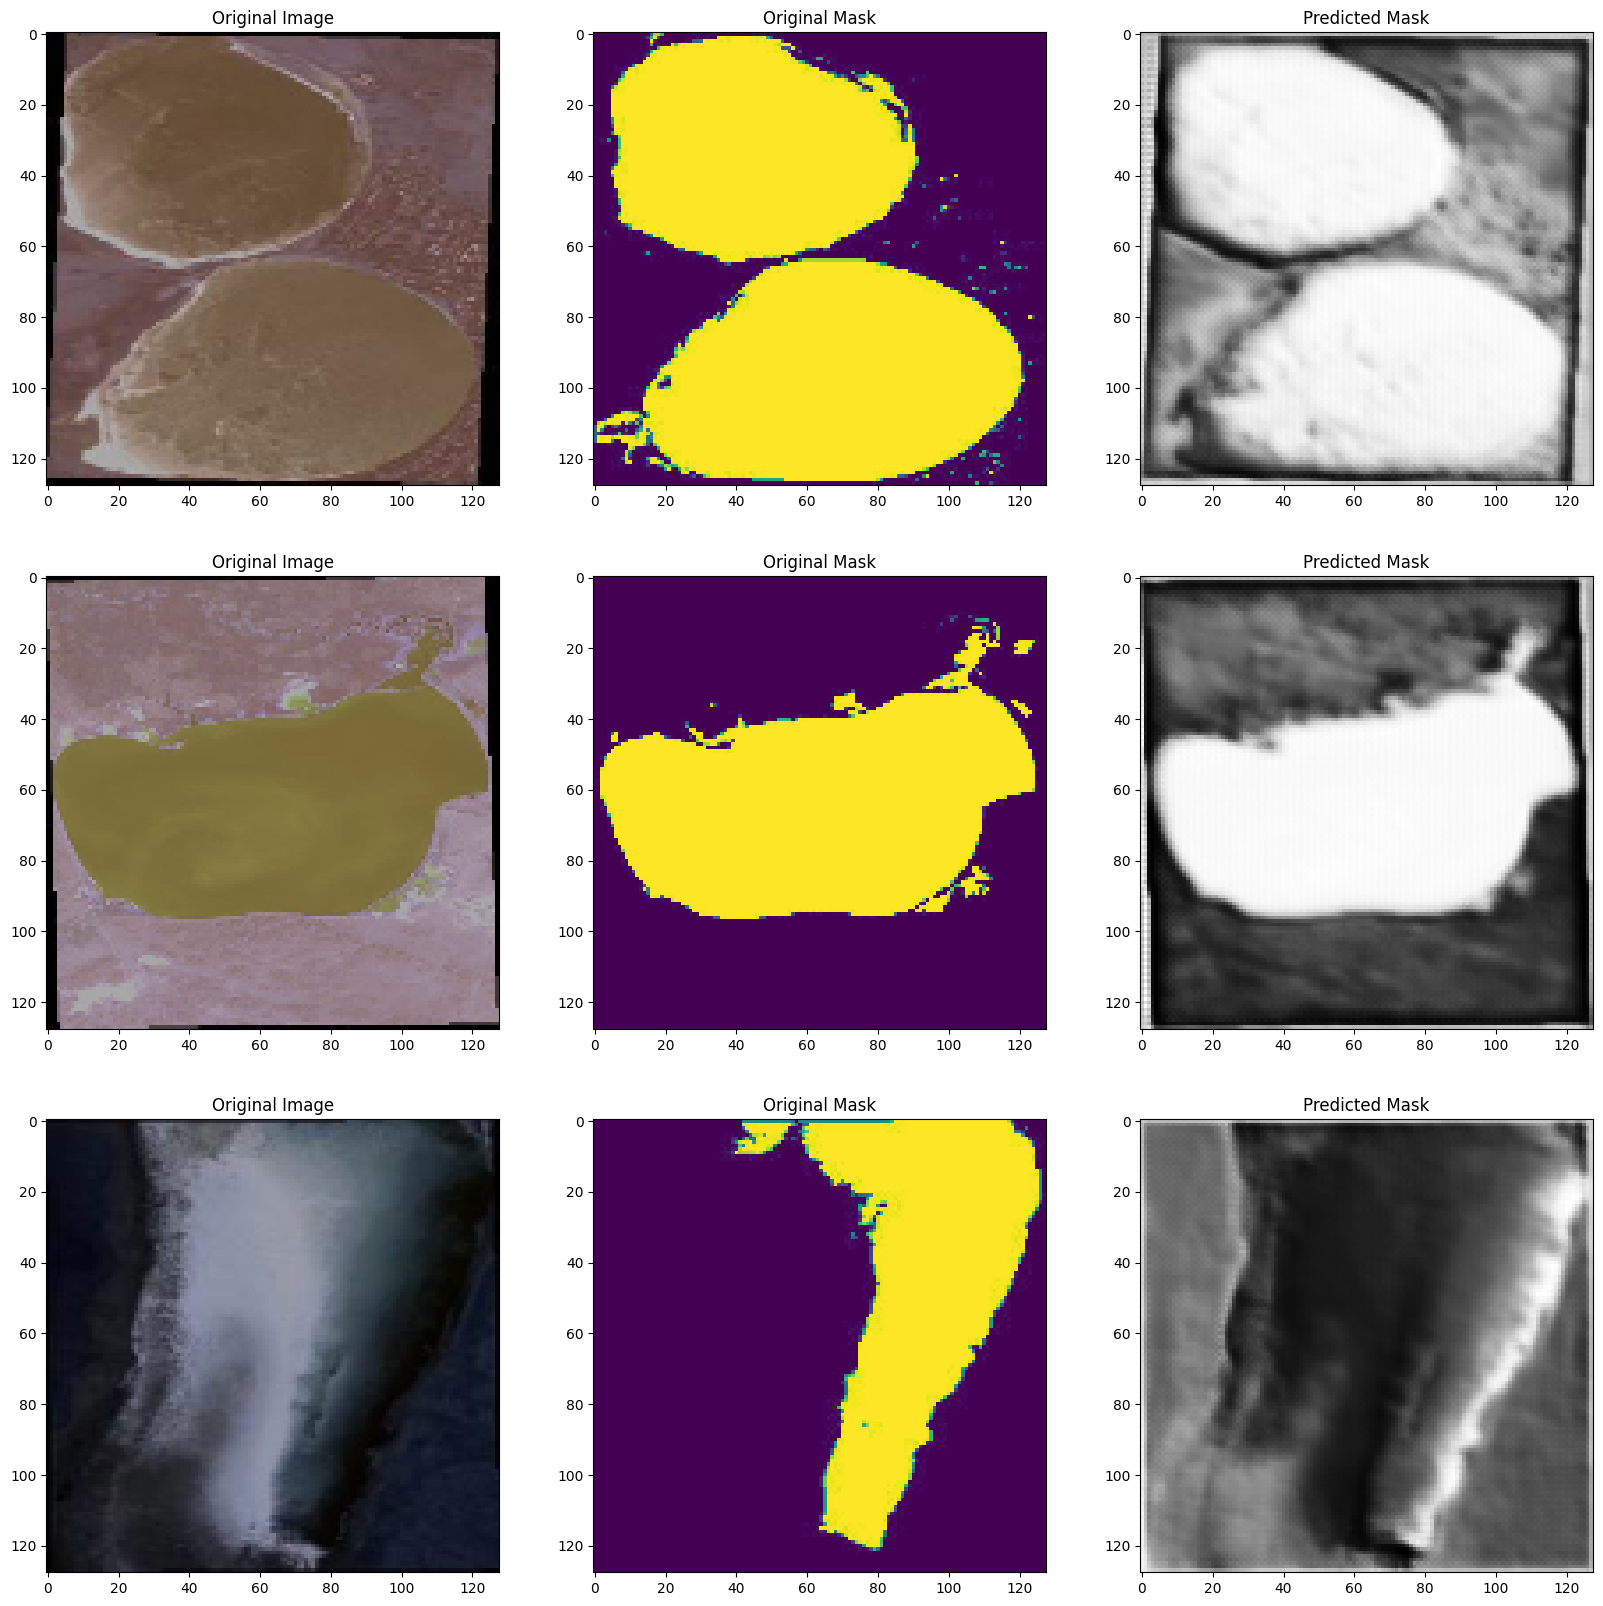

In [25]:
figure, axes = plt.subplots(3,3, figsize=(20,20))

for i in range(0,3):
    rand_num = random.randint(0,50)
    original_img = X_test[rand_num]
    axes[i,0].imshow(original_img)
    axes[i,0].title.set_text('Original Image')
    
    original_mask = y_test[rand_num]
    axes[i,1].imshow(original_mask)
    axes[i,1].title.set_text('Original Mask')
    
    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128,128)
    axes[i,2].imshow(predicted_mask, cmap='gray')
    axes[i,2].title.set_text('Predicted Mask')
